---
title: Decision Tree Classifier built from scratch
author: ["Hrriday V. Ruparel"]
date: "2024-01-24"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Classfication"]

---

#### Decision Tree Implementation

Model Implementation

In [1]:
from dataclasses import dataclass
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from metrics import *
np.random.seed(42)

@dataclass

class Next:
    def __init__(self,name, ptr = None):
        self.ptr = ptr
        self.name = name

class Node:
    def __init__(self, to_split=None, split_val=0.0, depth=float('inf'), decision = None):
        self.to_split = to_split
        self.split_val = split_val
        self.depth = depth
        self.decision = decision
        self.left_ptr = None
        self.right_ptr = None
        self.nexts = []

    def add_in_nexts(self,name, ptr=None):
        lst = self.nexts
        lst.append(Next(name = name,ptr = ptr))
        self.nexts = lst

class DecisionTree:
    criterion: Literal["information_gain", "gini_index"]
    max_depth: int  

    def __init__(self, criterion='information_gain', max_depth=4):
        self.criterion = criterion
        self.max_depth = max_depth
        self.Root = None    

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """
        Function to train and construct the decision tree
        """
        def dfconvertor(a):
            x=pd.DataFrame(a[0])
            x[a[1].name]=a[1]
            x=x.reset_index(drop=True)
            return x.iloc[:,:-1], x.iloc[:,-1]
        
        def make_tree(X: pd.DataFrame, y:pd.Series, features:list, criterion:str, max_depth:int, node_, value):
            
            # same condition for all cases 
            if(y.nunique() == 1):
                node_.decision = y.mode()[0]
                return

            # for discrete outputs
            elif(len(features) == 0 and (not check_ifreal(y))):
                node_.decision = y.mode()[0]
                return
            elif (node_.depth > max_depth and (not check_ifreal(y))):
                node_.decision = y.mode()[0] 
                return

            # for real outputs
            elif(len(features) == 0 and (check_ifreal(y))):
                node_.decision = y.mean() 
                return    
            elif (node_.depth > max_depth and (check_ifreal(y))):
                node_.decision = y.mean() 
                return         
            
            else:

                #  for discrete inputs
                if (not check_ifreal(X.iloc[:,0])):
                    opt_attr_ = opt_split_attribute(X, y, criterion, pd.Series(features))
                    node_.to_split = opt_attr_
                    for element in split_data(X, y, opt_attr_, 0):
                        Xi, yi = dfconvertor(element) 
                        node_.add_in_nexts(name = Xi[opt_attr_].unique()[0])
                        new_node = Node(depth = node_.depth + 1, split_val=value)
                        node_.nexts[-1].ptr = new_node 
                        features_ = [feature for feature in features if feature != opt_attr_]
                        make_tree(Xi, yi, features_, criterion, max_depth, new_node, value)
                    return 
                
                # for real inputs
                else:
                    # for RIRO
                    if check_ifreal(y):
                        opt_attribute, split_val = opt_attr(X, y)

                    #for RIDO    
                    else:
                        optimal_attribute = find_optimal_attribute(df_to_array(X), np.array(y))
                        opt_attribute = X.columns[optimal_attribute.feature_index]
                        split_val = optimal_attribute.split_value

                    # for real input
                    node_.to_split = opt_attribute
                    node_.split_val = split_val
                    t, r = split_data(X, y, opt_attribute, split_val)
                    left_df_X, left_df_y = dfconvertor(t)
                    right_df_X, right_df_y = dfconvertor(r)

                    new_node = Node(depth=node_.depth + 1)
                    node_.left_ptr = new_node
    
                    # features_ = [feature for feature in features if feature != opt_attribute]
                    make_tree(left_df_X, left_df_y, features, criterion, max_depth, new_node, value)

                    new_node_ = Node(depth=node_.depth + 1)
                    node_.right_ptr = new_node_

                    # _features_ = [feature for feature in features if feature != opt_attribute]
                    make_tree(right_df_X, right_df_y, features, criterion, max_depth, new_node_, value)

                return                        

            
        self.Root = Node(depth = 0, split_val = y.mean() if check_ifreal(y) else y.mode()[0])   
        make_tree(X, y, list(X.columns), self.criterion, self.max_depth, self.Root, self.Root.split_val)
        return None    
    
        pass

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        Funtion to run the decision tree on test inputs
        """

        # for discrete inputs
        # if (not check_ifreal(X.iloc[:,0])):
        #     def predict_from_node(feature_names: list, feature_values: list, node):
        #         if (node.decision is not None):
        #             return node.decision
        #         else:
        #             split_attribute = node.to_split
        #             val = feature_values[feature_names.index(split_attribute)]
        #             unique_list = node.nexts #.copy()
        #             for unique in unique_list:
        #                 if (unique.name ==  val):
        #                     feature_values_ = [element for i, element in enumerate(feature_values) if i != feature_names.index(split_attribute)]
        #                     feature_names_ = [element for i, element in enumerate(feature_names) if element != split_attribute]
        #                     return predict_from_node(feature_names_, feature_values_, unique.ptr)
        #             return None
    
        if (not check_ifreal(X.iloc[:,0])):
            def predict_from_node(X: pd.DataFrame, node):
                if (node.decision is not None):
                    return node.decision
                else:
                    split_attribute = node.to_split
                    split_attribute_val = X[split_attribute]
                    flag = 0
                    for i in node.nexts:
                        if i.name == split_attribute_val:
                            flag = 1
                            return predict_from_node(X,i.ptr)
                    if not flag:
                        return node.split_val

            def predict_(X: pd.DataFrame, Tree_Root):
                y = []
                for i in range(X.shape[0]):
                    y.append(predict_from_node(X.iloc[i,:], Tree_Root))
                return pd.Series(y)
            # Traverse the tree you constructed to return the predicted values for the given test inputs.

        else:
            # for real inputs
            def predict_from_node(dataFrame, root):
                ## Do check out for len(dataFrame.columns) == 0 condition
                if (root.decision is not None):
                    return root.decision

                split_attribute = root.to_split
                split_value = root.split_val

                if dataFrame[split_attribute][0] <= split_value:
                    return predict_from_node(dataFrame, root.left_ptr)

                else:
                    return predict_from_node(dataFrame, root.right_ptr)

            def predict_(X: pd.DataFrame, tree_root):
                y = []
                for i in range(X.shape[0]):
                    df = pd.DataFrame(X.iloc[i, :]).T
                    df.reset_index(inplace=True, drop=True)
                    y.append(predict_from_node(df, tree_root))
                return pd.Series(y)            

        return predict_(X, self.Root)
    
    def plot(self) -> None:
        """
        Function to plot the tree

        Output Example:
        ?(X1 > 4)
            Y: ?(X2 > 7)
                Y: Class A
                N: Class B
            N: Class C
        Where Y => Yes and N => No
        """

        def plot_(node_, depth):
            if (node_.left_ptr is not None or node_.right_ptr is not None and node_.nexts == []):
                return
            else:
                if (node_.to_split is None):
                    print(node_.decision)
                    return None
                else: # node_decision is None
                    print('?(',node_.to_split,')', sep='')
                    for element in node_.nexts:
                        print("   "*depth, element.name, ': ',end = '', sep = '')
                        plot_(element.ptr, depth+1)                

        def _plot_(node_, depth):
            if (node_.left_ptr == None and node_.right_ptr == None and node_.nexts != [] ):
                return
            else:
                if (node_.decision is not None):
                    print("   "*depth,node_.decision)
                    return None
                else: # node_decision is None
                    print("   "*depth,'?(', node_.to_split, '<=', node_.split_val, ')', sep='')
                    _plot_(node_.left_ptr, depth+1)

                    print("   "*depth,'?(', node_.to_split, '>', node_.split_val, ')', sep='')
                    _plot_(node_.right_ptr, depth+1)                        
        plot_(self.Root, 0)
        _plot_(self.Root,0)
        return None 
    



In [2]:
#test for DIDO
np.random.seed(42)
N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

num = 21
for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X.iloc[:num,:], y[:num])
    y_hat = tree.predict(X.iloc[num:,:])
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y[num:])},index = list(range(0,N-num)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y[num:]))
    for cls in y.unique():
        print(f'Class: {cls}')
        print("Precision: ", precision(y_hat, y[num:], cls))
        print("Recall: ", recall(y_hat, y[num:], cls))
        print()

,y_hat,y
0,0,0
1,0,1
2,0,3
3,2,3
4,3,1
5,0,2
6,0,0
7,0,4
8,0,0


?(3)
2: ?(0)
   3: ?(1)
      2: 0
      1: 3
      3: 3
   2: 0
   4: 0
   1: 0
   0: 0
0: ?(1)
   3: 0
   2: 2
   1: 2
   0: 0
4: ?(0)
   2: 3
   1: 1
1: ?(1)
   4: 4
   0: 0
   1: 0
3: ?(2)
   0: 2
   4: 4
   3: 2
Criteria : information_gain
Accuracy:  0.3333333333333333
Class: 0
Precision:  0.42857142857142855
Recall:  1.0

Class: 2
Precision:  0.0
Recall:  0.0

Class: 3
Precision:  0.0
Recall:  0.0

Class: 4
No predictions were made for class 4. Hence, precision is not defined.
Precision:  None
Recall:  0.0

Class: 1
No predictions were made for class 1. Hence, precision is not defined.
Precision:  None
Recall:  0.0



,y_hat,y
0,0,0
1,0,1
2,0,3
3,2,3
4,3,1
5,0,2
6,0,0
7,0,4
8,0,0


?(3)
2: ?(0)
   3: ?(1)
      2: 0
      1: 3
      3: 3
   2: 0
   4: 0
   1: 0
   0: 0
0: ?(1)
   3: 0
   2: 2
   1: 2
   0: 0
4: ?(0)
   2: 3
   1: 1
1: ?(1)
   4: 4
   0: 0
   1: 0
3: ?(2)
   0: 2
   4: 4
   3: 2
Criteria : gini_index
Accuracy:  0.3333333333333333
Class: 0
Precision:  0.42857142857142855
Recall:  1.0

Class: 2
Precision:  0.0
Recall:  0.0

Class: 3
Precision:  0.0
Recall:  0.0

Class: 4
No predictions were made for class 4. Hence, precision is not defined.
Precision:  None
Recall:  0.0

Class: 1
No predictions were made for class 1. Hence, precision is not defined.
Precision:  None
Recall:  0.0



In [3]:
# test for DIRO
np.random.seed(42)
N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

num = 21
for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X.iloc[:num,:], y[:num])
    y_hat = tree.predict(X.iloc[num:,:])
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y[num:])},index = list(range(0,N-num)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y[num:]))
    print("MAE: ", mae(y_hat, y[num:]))

,y_hat,y
0,-0.146786,-0.084165
1,0.301323,1.237016
2,-0.146786,-1.426479
3,-0.146786,0.338023
4,-0.146473,1.974571
5,-0.146786,1.965035
6,-0.846017,-1.939911
7,-0.146786,-0.762627
8,-0.146786,0.168659


?(1)
2: ?(0)
   3: 0.724083251525877
   4: -0.8703049545610739
   2: -1.3099506872124742
3: ?(4)
   3: ?(2)
      3: -0.25576463695894236
      4: 0.3013228009496343
   4: ?(0)
      2: 0.8499212040623495
      3: 1.004986880702632
   2: -0.6660606202304288
   0: -0.4417660232260129
0: ?(3)
   2: -1.3113242257511093
   1: -1.0962657952813555
   0: -0.5137874915082461
   4: -0.14647280674161622
4: ?(0)
   1: -0.5066432196315238
   2: 2.943663416481284
   4: -0.8224893687800624
1: ?(2)
   3: ?(0)
      4: 0.9148843219260121
      0: 1.0867270230392738
   1: -1.4585169209867577
   4: -0.6627383133782134
   0: -0.8460170164557059
Criteria : information_gain
RMSE:  1.2195665143747434
MAE:  1.0023179706204957


,y_hat,y
0,-0.146786,-0.084165
1,-0.146786,1.237016
2,-0.146786,-1.426479
3,-0.146786,0.338023
4,-0.146473,1.974571
5,0.849921,1.965035
6,-1.458517,-1.939911
7,1.004987,-0.762627
8,-0.146786,0.168659


?(1)
2: ?(0)
   3: 0.724083251525877
   4: -0.8703049545610739
   2: -1.3099506872124742
3: ?(0)
   4: ?(2)
      3: -0.25576463695894236
      4: 0.3013228009496343
   2: 0.8499212040623495
   3: ?(2)
      0: -0.6660606202304288
      3: 1.004986880702632
   1: -0.4417660232260129
0: ?(3)
   2: -1.3113242257511093
   1: -1.0962657952813555
   0: -0.5137874915082461
   4: -0.14647280674161622
4: ?(0)
   1: -0.5066432196315238
   2: 2.943663416481284
   4: -0.8224893687800624
1: ?(0)
   4: 0.9148843219260121
   1: -1.4585169209867577
   3: ?(2)
      4: -0.6627383133782134
      0: -0.8460170164557059
   0: 1.0867270230392738
Criteria : gini_index
RMSE:  1.2013647062227255
MAE:  1.001281850071568


In [4]:
# test for RIRO
np.random.seed(42)
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))

num = 21
for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X.iloc[:num,:], y[:num])
    y_hat = tree.predict(X.iloc[num:,:])
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y[num:])},index = list(range(0,N-num)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y[num:]))
    print("MAE: ", mae(y_hat, y[num:]))

,y_hat,y
0,-0.245388,-0.815810
1,0.250493,-0.077102
2,1.158596,0.341152
3,0.293072,0.276691
4,0.721819,0.827183
5,0.473833,0.013002
6,-0.897682,1.453534
7,-0.245388,-0.264657
8,1.158596,2.720169


?(1<=0.3506423035433175)
   ?(2.0<=-0.7919860527670518)
      ?(0.0<=-0.8500089439081561)
          0.4738329209117875
      ?(0.0>-0.8500089439081561)
          1.158595579007404
   ?(2.0>-0.7919860527670518)
      ?(3.0<=0.02125729698958631)
         ?(0.0<=0.78828567931571)
            ?(1.0<=-0.7392804369523404)
                -0.24104886043268214
            ?(1.0>-0.7392804369523404)
                -0.8786447031910382
         ?(0.0>0.78828567931571)
             0.29307247329868125
      ?(3.0>0.02125729698958631)
         ?(3.0<=0.34644972822559905)
            ?(1.0<=-0.37608522749223366)
                0.7218191061881409
            ?(1.0>-0.37608522749223366)
                0.4127809269364983
         ?(3.0>0.34644972822559905)
            ?(3.0<=1.0673530726244467)
                -0.897681994289516
            ?(3.0>1.0673530726244467)
                0.25049285034587654
?(1>0.3506423035433175)
   ?(0.0<=-0.41792178458928875)
      ?(0.0<=-0.5517318279069667)
         

,y_hat,y
0,-0.245388,-0.815810
1,0.250493,-0.077102
2,1.158596,0.341152
3,0.293072,0.276691
4,0.721819,0.827183
5,0.473833,0.013002
6,-0.897682,1.453534
7,-0.245388,-0.264657
8,1.158596,2.720169


?(1<=0.3506423035433175)
   ?(2.0<=-0.7919860527670518)
      ?(0.0<=-0.8500089439081561)
          0.4738329209117875
      ?(0.0>-0.8500089439081561)
          1.158595579007404
   ?(2.0>-0.7919860527670518)
      ?(3.0<=0.02125729698958631)
         ?(0.0<=0.78828567931571)
            ?(1.0<=-0.7392804369523404)
                -0.24104886043268214
            ?(1.0>-0.7392804369523404)
                -0.8786447031910382
         ?(0.0>0.78828567931571)
             0.29307247329868125
      ?(3.0>0.02125729698958631)
         ?(3.0<=0.34644972822559905)
            ?(1.0<=-0.37608522749223366)
                0.7218191061881409
            ?(1.0>-0.37608522749223366)
                0.4127809269364983
         ?(3.0>0.34644972822559905)
            ?(3.0<=1.0673530726244467)
                -0.897681994289516
            ?(3.0>1.0673530726244467)
                0.25049285034587654
?(1>0.3506423035433175)
   ?(0.0<=-0.41792178458928875)
      ?(0.0<=-0.5517318279069667)
         

In [5]:
# test for RIDO 
np.random.seed(42)    
N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

num = 21

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X.iloc[:num,:], y[:num])
    y_hat = tree.predict(X.iloc[num:,:])
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y[num:])},index = list(range(0,N-num)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y[num:]))
    for cls in y.unique():
        print(f'Class: {cls}')
        print("Precision: ", precision(y_hat, y[num:], cls))
        print("Recall: ", recall(y_hat, y[num:], cls))
        print()

,y_hat,y
0,2,4
1,3,3
2,4,2
3,3,0
4,0,0
5,0,3
6,1,2
7,0,2
8,0,4


?(4<=-1.4454128458513593)
   ?(0.0<=-0.5916309506035855)
       0
   ?(0.0>-0.5916309506035855)
      ?(0.0<=0.7801845421853171)
          2
      ?(0.0>0.7801845421853171)
          4
?(4>-1.4454128458513593)
   ?(1.0<=1.7157455000081647)
      ?(4.0<=0.6775429329900813)
         ?(4.0<=-0.5947512395651535)
            ?(0.0<=0.5682840703666555)
                0
            ?(0.0>0.5682840703666555)
                1
         ?(4.0>-0.5947512395651535)
            ?(2.0<=-0.13759315591942284)
                0
            ?(2.0>-0.13759315591942284)
                3
      ?(4.0>0.6775429329900813)
         ?(3.0<=0.4714698601222159)
             1
         ?(3.0>0.4714698601222159)
             4
   ?(1.0>1.7157455000081647)
       2
Criteria : information_gain
Accuracy:  0.2222222222222222
Class: 0
Precision:  0.25
Recall:  0.5

Class: 3
Precision:  0.5
Recall:  0.5

Class: 2
Precision:  0.0
Recall:  0.0

Class: 4
Precision:  0.0
Recall:  0.0

Class: 1
Precision:  0.0
No instance o

,y_hat,y
0,2,4
1,3,3
2,4,2
3,3,0
4,0,0
5,0,3
6,1,2
7,0,2
8,0,4


?(4<=-1.4454128458513593)
   ?(0.0<=-0.5916309506035855)
       0
   ?(0.0>-0.5916309506035855)
      ?(0.0<=0.7801845421853171)
          2
      ?(0.0>0.7801845421853171)
          4
?(4>-1.4454128458513593)
   ?(1.0<=1.7157455000081647)
      ?(4.0<=0.6775429329900813)
         ?(4.0<=-0.5947512395651535)
            ?(0.0<=0.5682840703666555)
                0
            ?(0.0>0.5682840703666555)
                1
         ?(4.0>-0.5947512395651535)
            ?(2.0<=-0.13759315591942284)
                0
            ?(2.0>-0.13759315591942284)
                3
      ?(4.0>0.6775429329900813)
         ?(3.0<=0.4714698601222159)
             1
         ?(3.0>0.4714698601222159)
             4
   ?(1.0>1.7157455000081647)
       2
Criteria : gini_index
Accuracy:  0.2222222222222222
Class: 0
Precision:  0.25
Recall:  0.5

Class: 3
Precision:  0.5
Recall:  0.5

Class: 2
Precision:  0.0
Recall:  0.0

Class: 4
Precision:  0.0
Recall:  0.0

Class: 1
Precision:  0.0
No instance of clas

Text(0, 0.5, '$x_2$')

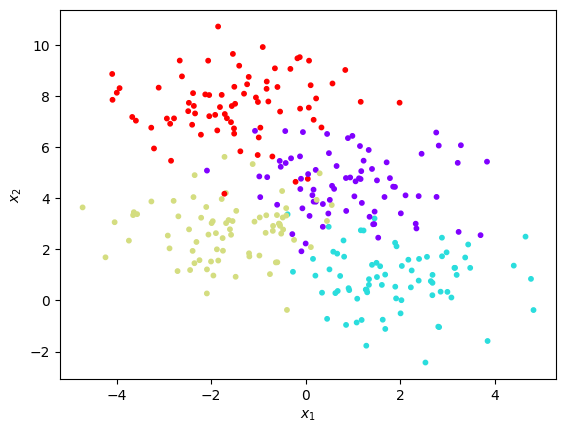

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='rainbow')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

In [7]:
# test for RIDO 
np.random.seed(42)    
N = 300
P = 4
X = pd.DataFrame(X)
y = pd.Series(y, dtype="category")

num = int(N*0.7)

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X.iloc[:num,:], y[:num])
    y_hat = tree.predict(X.iloc[num:,:])
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y[num:])},index = list(range(0,N-num)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y[num:]))
    for cls in y.unique():
        print(f'Class: {cls}')
        print("Precision: ", precision(y_hat, y[num:], cls))
        print("Recall: ", recall(y_hat, y[num:], cls))
        print()

,y_hat,y
0,0,0
1,2,2
2,0,0
3,0,0
4,3,3
...,...,...
85,0,1
86,1,1
87,3,0
88,3,3


?(1<=3.744584695617445)
   ?(0.0<=-0.38840127416989967)
       2
   ?(0.0>-0.38840127416989967)
      ?(1.0<=2.177059559323637)
          1
      ?(1.0>2.177059559323637)
         ?(1.0<=3.6742256596476213)
            ?(0.0<=0.469146602388832)
                0
            ?(0.0>0.469146602388832)
                0
         ?(1.0>3.6742256596476213)
             2
?(1>3.744584695617445)
   ?(1.0<=6.692241377858988)
      ?(0.0<=-0.9872897383437698)
         ?(1.0<=5.661767523442929)
            ?(1.0<=4.114941740589099)
                2
            ?(1.0>4.114941740589099)
                2
         ?(1.0>5.661767523442929)
            ?(1.0<=6.589666936280905)
                3
            ?(1.0>6.589666936280905)
                0
      ?(0.0>-0.9872897383437698)
         ?(1.0<=4.761010383499839)
            ?(1.0<=4.205715190188698)
                0
            ?(1.0>4.205715190188698)
                0
         ?(1.0>4.761010383499839)
            ?(1.0<=4.775306489805355)
    

,y_hat,y
0,0,0
1,2,2
2,0,0
3,0,0
4,3,3
...,...,...
85,0,1
86,1,1
87,3,0
88,3,3


?(1<=3.744584695617445)
   ?(0.0<=-0.38840127416989967)
       2
   ?(0.0>-0.38840127416989967)
      ?(1.0<=2.177059559323637)
          1
      ?(1.0>2.177059559323637)
         ?(1.0<=3.6742256596476213)
            ?(0.0<=0.469146602388832)
                0
            ?(0.0>0.469146602388832)
                0
         ?(1.0>3.6742256596476213)
             2
?(1>3.744584695617445)
   ?(1.0<=6.692241377858988)
      ?(0.0<=-0.9872897383437698)
         ?(1.0<=5.661767523442929)
            ?(1.0<=4.114941740589099)
                2
            ?(1.0>4.114941740589099)
                2
         ?(1.0>5.661767523442929)
            ?(1.0<=6.589666936280905)
                3
            ?(1.0>6.589666936280905)
                0
      ?(0.0>-0.9872897383437698)
         ?(1.0<=4.761010383499839)
            ?(1.0<=4.205715190188698)
                0
            ?(1.0>4.205715190188698)
                0
         ?(1.0>4.761010383499839)
            ?(1.0<=4.775306489805355)
    

In [8]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([0, 0, 1, 1, 2, 2])

# test for RIRO
np.random.seed(42)
N = 6
X = pd.DataFrame(x)
y = pd.Series(y)

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y)},index = list(range(0,N)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))

,y_hat,y
0,0,0
1,0,0
2,1,1
3,1,1
4,2,2
5,2,2


?(0<=2.5)
    0
?(0>2.5)
   ?(0.0<=4.5)
       1
   ?(0.0>4.5)
       2
Criteria : information_gain
RMSE:  0.0
MAE:  0.0


,y_hat,y
0,0,0
1,0,0
2,1,1
3,1,1
4,2,2
5,2,2


?(0<=2.5)
    0
?(0>2.5)
   ?(0.0<=4.5)
       1
   ?(0.0>4.5)
       2
Criteria : gini_index
RMSE:  0.0
MAE:  0.0


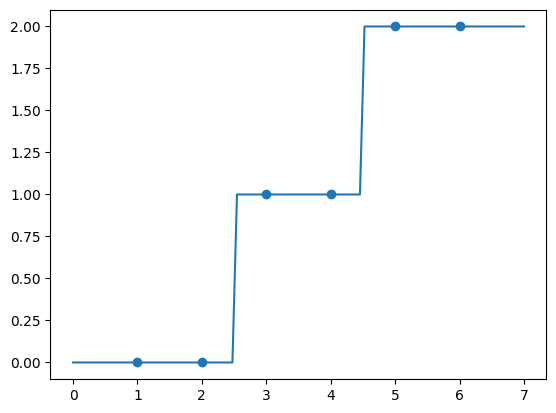

In [9]:
t = pd.DataFrame(np.linspace(0,7,100))

t_pred = tree.predict(t)
plt.plot(t,t_pred)
plt.scatter(x,y)
plt.show()
    

In [10]:
x = np.linspace(0,7,100)
y = np.sin(x)

# test for RIRO
np.random.seed(42)
N = 100
X = pd.DataFrame(x)
y = pd.Series(y)

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    display(pd.concat((pd.DataFrame({'y_hat':y_hat}),pd.DataFrame({'y':list(y)},index = list(range(0,N)))),axis=1))
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))

,y_hat,y
0,0.000000,0.000000
1,0.070648,0.070648
2,0.140943,0.140943
3,0.210534,0.210534
4,0.279073,0.279073
...,...,...
95,0.387916,0.420491
96,0.513855,0.483539
97,0.513855,0.544171
98,0.629535,0.602083


?(0<=3.005050505050505)
   ?(0.0<=0.5303030303030303)
      ?(0.0<=0.24747474747474746)
         ?(0.0<=0.10606060606060605)
            ?(0.0<=0.03535353535353535)
                0.0
            ?(0.0>0.03535353535353535)
                0.07064816888592165
         ?(0.0>0.10606060606060605)
            ?(0.0<=0.17676767676767674)
                0.1409432800978515
            ?(0.0>0.17676767676767674)
                0.21053404033479042
      ?(0.0>0.24747474747474746)
         ?(0.0<=0.38888888888888884)
            ?(0.0<=0.3181818181818182)
                0.27907267622443427
            ?(0.0>0.3181818181818182)
                0.34621667228835856
         ?(0.0>0.38888888888888884)
            ?(0.0<=0.45959595959595956)
                0.41163048263136653
            ?(0.0>0.45959595959595956)
                0.47498720780099063
   ?(0.0>0.5303030303030303)
      ?(0.0<=2.51010101010101)
         ?(0.0<=0.8838383838383838)
            ?(0.0<=0.6717171717171717)
             

,y_hat,y
0,0.000000,0.000000
1,0.070648,0.070648
2,0.140943,0.140943
3,0.210534,0.210534
4,0.279073,0.279073
...,...,...
95,0.387916,0.420491
96,0.513855,0.483539
97,0.513855,0.544171
98,0.629535,0.602083


?(0<=3.005050505050505)
   ?(0.0<=0.5303030303030303)
      ?(0.0<=0.24747474747474746)
         ?(0.0<=0.10606060606060605)
            ?(0.0<=0.03535353535353535)
                0.0
            ?(0.0>0.03535353535353535)
                0.07064816888592165
         ?(0.0>0.10606060606060605)
            ?(0.0<=0.17676767676767674)
                0.1409432800978515
            ?(0.0>0.17676767676767674)
                0.21053404033479042
      ?(0.0>0.24747474747474746)
         ?(0.0<=0.38888888888888884)
            ?(0.0<=0.3181818181818182)
                0.27907267622443427
            ?(0.0>0.3181818181818182)
                0.34621667228835856
         ?(0.0>0.38888888888888884)
            ?(0.0<=0.45959595959595956)
                0.41163048263136653
            ?(0.0>0.45959595959595956)
                0.47498720780099063
   ?(0.0>0.5303030303030303)
      ?(0.0<=2.51010101010101)
         ?(0.0<=0.8838383838383838)
            ?(0.0<=0.6717171717171717)
             

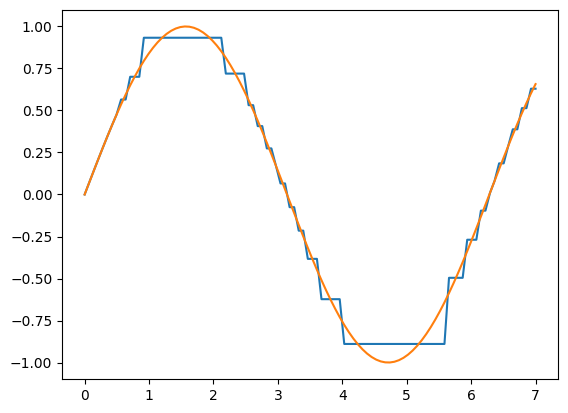

In [11]:
t = pd.DataFrame(np.linspace(0,7,100))

t_pred = tree.predict(t)
plt.plot(t,t_pred)
plt.plot(x,y)
plt.show()